In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
from typing import Optional, Tuple

In [2]:
class RandomWalkSimulator:
    def __init__(self, Q: torch.Tensor, H: torch.Tensor, R: torch.Tensor):
        MVN = torch.distributions.MultivariateNormal
        self.Q, self.H, self.R = Q, H, R
        self.device, self.dtype = Q.device, Q.dtype
        self.N = Q.shape[0]
        self.M = H.shape[0]

        self.proc = MVN(loc=torch.zeros(self.N, device=self.device, dtype=self.dtype),
                        covariance_matrix=Q)
        self.meas = MVN(loc=torch.zeros(self.M, device=self.device, dtype=self.dtype),
                        covariance_matrix=R)

    def __call__(self, T: int, B: int, device):
        x0 = torch.randn(B, self.N, device=self.device, dtype=self.dtype)
        W = self.proc.rsample((B, T))                 # (B,T,N)
        X = x0.unsqueeze(1) + W.cumsum(dim=1)         # (B,T,N)
        V = self.meas.rsample((B, T))                 # (B,T,M)
        Y = X @ self.H.t() + V                        # (B,T,M)
        return X, Y, x0

In [3]:
class KalmanFilterND:
    """
    Discrete-time, batched Kalman filter (time-invariant A,Q,H,R).
    Init with system matrices; call with (Y, x0) to run the filter.

    Init args:
      A:  (N,N)            state transition
      Q:  (N,N)            process covariance
      H:  (M,N)            measurement matrix
      R:  (M,M)            measurement covariance
      P0: (N,N) or (B,N,N) initial covariance (shared or per-batch)

    Call:
      Y:  (B,T,M) measurements
      x0: (B,N)   initial state per sequence

    Returns:
      Xhat:  (B,T,N)   filtered means
      P_all: (B,T,N,N) filtered covariances
      K_all: (B,T,N,M) Kalman gains
      Innov: (B,T,M)   innovations (y - H x_pred)
      S_all: (B,T,M,M) innovation covariances
    """
    def __init__(self, A: torch.Tensor, Q: torch.Tensor,
                 H: torch.Tensor, R: torch.Tensor, P0: torch.Tensor):
        self.A  = A
        self.Q  = Q
        self.H  = H
        self.R  = R
        self.P0 = P0
        self.AT = A.t()
        self.HT = H.t()
        self.device = A.device
        self.dtype  = A.dtype
        self.N = A.shape[0]
        self.M = H.shape[0]

    @torch.no_grad()
    def __call__(self, Y: torch.Tensor, x0: torch.Tensor):
        B, T, M = Y.shape
        N = self.N
        A, AT, H, HT, Q, R = self.A, self.AT, self.H, self.HT, self.Q, self.R

        # Pre-expand constant matrices across batch as views (no copy) for bmm
        A_b, AT_b = A.expand(B, N, N), AT.expand(B, N, N)
        H_b, HT_b = H.expand(B, M, N), HT.expand(B, N, M)
        Q_b, R_b  = Q.expand(B, N, N), R.expand(B, M, M)

        # Allocate outputs
        Xhat  = torch.empty(B, T, N, device=Y.device, dtype=Y.dtype)
        P_all = torch.empty(B, T, N, N, device=Y.device, dtype=Y.dtype)
        K_all = torch.empty(B, T, N, M, device=Y.device, dtype=Y.dtype)
        S_all = torch.empty(B, T, M, M, device=Y.device, dtype=Y.dtype)
        Innov = torch.empty(B, T, M, device=Y.device, dtype=Y.dtype)

        # Broadcast P0 if shared; clone because we'll update in-place
        P = self.P0 if self.P0.dim() == 3 else self.P0.unsqueeze(0).expand(B, N, N).clone()
        x = x0.clone()

        for t in range(T):
            # ---- Predict ----
            x = torch.bmm(A_b, x.unsqueeze(-1)).squeeze(-1)     # x = A x
            P = torch.bmm(A_b, torch.bmm(P, AT_b)) + Q_b        # P = A P A^T + Q

            # ---- Update ----
            y_t = Y[:, t, :]                                    # (B,M)
            r   = y_t - torch.bmm(H_b, x.unsqueeze(-1)).squeeze(-1)   # innovation
            PHT = torch.bmm(P, HT_b)                                  # (B,N,M)
            S   = torch.bmm(H_b, PHT) + R_b                            # (B,M,M), SPD

            # K = P H^T S^{-1} via batched Cholesky solve
            L = torch.linalg.cholesky(S)                                # (B,M,M)
            K = torch.cholesky_solve(PHT.transpose(1, 2), L).transpose(1, 2)  # (B,N,M)

            x = x + torch.bmm(K, r.unsqueeze(-1)).squeeze(-1)           # state update
            P = P - torch.bmm(K, torch.bmm(S, K.transpose(1, 2)))       # covariance update

            # Save
            Xhat[:, t]  = x
            P_all[:, t] = P
            K_all[:, t] = K
            S_all[:, t] = S
            Innov[:, t] = r

        return Xhat, P_all, K_all, Innov, S_all

In [4]:
class NN_Kalman(nn.Module):
    """Single-head SDPA with strict H-step causal window (no self)."""
    def __init__(self, dim, H, device):
        super().__init__()
        self.dim, self.H, self.device = dim, H, device
        self.qkv = nn.Linear(dim, 3 * dim, bias=True, device=device)
        self._mask_cache = None  # caches (T,T) boolean mask on the right device

    @torch.no_grad()
    def _mask(self, T: int, device):
        m = self._mask_cache
        if (m is None) or (m.shape != (T, T)) or (m.device != device):
            idx = torch.arange(T, device=device)
            i, j = idx[:, None], idx[None, :]
            delta = i - j
            m  = (delta >= 1) & (delta <= self.H)  # strictly previous H tokens
            # Optional safety to avoid a fully masked first row:
            # if T > 0: m[0, 0] = False
            self._mask_cache = m
        return self._mask_cache

    def forward(self, x):  # x: (B,T,dim) -> (B,T,dim)
        B, T, D = x.shape
        q, k, v = self.qkv(x).chunk(3, dim=-1)        # (B,T,D) each
        q = q.unsqueeze(1); k = k.unsqueeze(1); v = v.unsqueeze(1)  # (B,1,T,D)
        attn_mask = self._mask(T, x.device).unsqueeze(0).unsqueeze(0)  # (1,1,T,T)
        out = F.scaled_dot_product_attention(q, k, v, attn_mask=attn_mask, is_causal=False)
        return out.squeeze(1)  # (B,T,dim)

In [5]:
def steady_state_kalman_gain(A, C, Q, R, tol=1e-9, iters=10_000):
    P = Q.clone()
    for _ in range(iters):
        S = C @ P @ C.t() + R
        L = torch.linalg.solve(S, (A @ P @ C.t()).t()).t()
        Pn = A @ P @ A.t() - L @ S @ L.t() + Q
        if torch.norm(Pn - P, p='fro') <= tol * (1 + torch.norm(P, p='fro')): P = Pn; break
        P = Pn
    return L

def _phi(u):
    B,T,n = u.shape
    one = torch.ones(B,T,1, device=u.device, dtype=u.dtype)
    return torch.cat([one, u, (u.unsqueeze(-1)*u.unsqueeze(-2)).reshape(B,T,n*n)], -1)

def _D_from_P(P):
    n = P.shape[0]; d = 1 + n + n*n
    D = torch.zeros(d,d, device=P.device, dtype=P.dtype)
    D[1:1+n, 1:1+n] = -2*P
    D[1+n:, :1] = P.reshape(-1,1)
    D[:1, 1+n:] = P.reshape(1,-1)
    return D

def _svd_factor(A):
    U,S,Vh = torch.linalg.svd(A, full_matrices=False)
    r = torch.sqrt(torch.abs(S)); s = torch.sign(S)
    return U*r, Vh.t()*(r*s)

class TransformerKalmanFromMatrices(nn.Module):
    def __init__(self, A, C, L, beta, H, device=None, metric=None):
        super().__init__()
        device = device or A.device
        A,C,L = A.to(device), C.to(device), L.to(device)
        n,p = A.shape[0], C.shape[0]

        self.register_buffer("W", torch.cat([A - L@C, L], 1))
        P = (beta*torch.eye(n, device=device, dtype=A.dtype)) if metric is None else (beta*metric.to(device=device, dtype=A.dtype))
        D = _D_from_P(P); WQ,WK = _svd_factor(-D); d,r = WQ.shape

        self.lin_Q = nn.Linear(d, r, bias=False, device=device)
        self.lin_K = nn.Linear(d, r, bias=False, device=device)
        self.lin_V = nn.Linear(d, n, bias=False, device=device)
        with torch.no_grad():
            self.lin_Q.weight.copy_(WQ.t()); self.lin_K.weight.copy_(WK.t())
            WV = torch.zeros(n,d, device=device, dtype=A.dtype); WV[:,1:1+n] = torch.eye(n, device=device, dtype=A.dtype)
            self.lin_V.weight.copy_(WV)
        for p_ in self.parameters(): p_.requires_grad_(False)

        self.n, self.p, self.H = n, p, H
        self.softmax = nn.Softmax(-1)
        self._mask = None

    @torch.no_grad()
    def _causal_window(self, T, device):
        m = self._mask
        if (m is None) or (m.shape != (T,T)) or (m.device != device):
            keep = torch.tril(torch.ones(T,T, device=device)) * torch.triu(torch.ones(T,T, device=device), -(self.H-1))
            m = torch.full((T,T), float('-inf'), device=device).masked_fill(keep.bool(), 0.0)
            self._mask = m
        return m

    @torch.no_grad()
    def forward(self, xhat_prev, y_prev):
        z = torch.cat([xhat_prev, y_prev], -1)
        u = torch.einsum('nm,btm->btn', self.W, z)
        tok = _phi(u)
        Q = self.lin_Q(tok); K = self.lin_K(tok); V = self.lin_V(tok)
        logits = torch.einsum('btr,bsr->bts', Q, K) + self._causal_window(Q.size(1), Q.device)
        attn = self.softmax(logits)
        return torch.einsum('bts,bsn->btn', attn, V)

In [6]:
def train(network, sim, env, steps, B , device):

  optimizer = torch.optim.Adam(network.parameters(), lr=1e-3)
  loss_fn = nn.MSELoss()

  for i in range(steps):
      X, Y, x0 = sim(T=T, B=B, device=device)  # (pool_B,T,·)


      X_pred = network(Y)      # (B,T,N)
      loss = loss_fn(X_pred, X)

      optimizer.zero_grad(set_to_none=True)
      loss.backward()
      optimizer.step()

      if (i + 1) % 100 == 0 or i == 0:
          print(f"Step {i+1}/{steps}  Loss: {loss.item():.6f}")


In [7]:
torch.manual_seed(0)
T = 400
N = 6
M = N
B = 2**10
History = 5
steps = 5000

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype  = torch.float32

A = torch.eye(N, device=device, dtype=dtype)
Q = (1e-3) * torch.eye(N, device=device, dtype=dtype)
H = torch.eye(M, N, device=device, dtype=dtype)
R = (5e-2) * torch.eye(M, device=device, dtype=dtype)
P0 = torch.eye(N, device=device, dtype=dtype)

sim = RandomWalkSimulator(Q=Q, H=H, R=R)
kf  = KalmanFilterND(A, Q, H, R, P0)

with torch.no_grad():
    X_true, Y, x0 = sim(T=T, B=B, device=device)
    Xhat, P_all, K_all, Innov, S_all = kf(Y, x0)

network = NN_Kalman(dim=N, H=History, device=device).to(device)

# --- Build Transformer Kalman (trimmed versions assumed imported) ---
def steady_state_kalman_gain(A, C, Q, R, tol=1e-9, iters=10_000):
    P = Q.clone()
    for _ in range(iters):
        S = C @ P @ C.t() + R
        L = torch.linalg.solve(S, (A @ P @ C.t()).t()).t()
        Pn = A @ P @ A.t() - L @ S @ L.t() + Q
        if torch.norm(Pn - P, p='fro') <= tol * (1 + torch.norm(P, p='fro')): P = Pn; break
        P = Pn
    return L

C_meas = H
L_gain = steady_state_kalman_gain(A, C_meas, Q, R)
beta   = 10.0

tf_layer = TransformerKalmanFromMatrices(A, C_meas, L_gain, beta=beta, H=History, device=device)

In [8]:
train(network, sim, T, steps, B, device)

Step 1/5000  Loss: 1.604889
Step 100/5000  Loss: 1.167257
Step 200/5000  Loss: 0.859778
Step 300/5000  Loss: 0.665156
Step 400/5000  Loss: 0.507488
Step 500/5000  Loss: 0.408764
Step 600/5000  Loss: 0.322292
Step 700/5000  Loss: 0.242209
Step 800/5000  Loss: 0.189283
Step 900/5000  Loss: 0.146163
Step 1000/5000  Loss: 0.108812
Step 1100/5000  Loss: 0.083143
Step 1200/5000  Loss: 0.064604
Step 1300/5000  Loss: 0.049911
Step 1400/5000  Loss: 0.040536
Step 1500/5000  Loss: 0.033182
Step 1600/5000  Loss: 0.028634
Step 1700/5000  Loss: 0.025004
Step 1800/5000  Loss: 0.022698
Step 1900/5000  Loss: 0.020697
Step 2000/5000  Loss: 0.019793
Step 2100/5000  Loss: 0.018246
Step 2200/5000  Loss: 0.017570
Step 2300/5000  Loss: 0.016873
Step 2400/5000  Loss: 0.016389
Step 2500/5000  Loss: 0.015886
Step 2600/5000  Loss: 0.015615
Step 2700/5000  Loss: 0.015302
Step 2800/5000  Loss: 0.015208
Step 2900/5000  Loss: 0.014996
Step 3000/5000  Loss: 0.014973
Step 3100/5000  Loss: 0.014751
Step 3200/5000  Loss

In [13]:
T_eval      = 10 * T
B_eval      = 100
outer_loops = 40

@torch.no_grad()
def shift_prev_torch(seq):
    prev = torch.zeros_like(seq)
    prev[:, 1:] = seq[:, :-1]
    return prev

# on the same device as computations
sum_err_kf     = torch.zeros(T_eval, device=device, dtype=dtype)
sum_err_nn     = torch.zeros(T_eval, device=device, dtype=dtype)
sum_err_tf     = torch.zeros(T_eval, device=device, dtype=dtype)
sum_dist_nn_kf = torch.zeros(T_eval, device=device, dtype=dtype)
sum_dist_tf_kf = torch.zeros(T_eval, device=device, dtype=dtype)

total_series = 0

with torch.no_grad():
    for _ in range(outer_loops):
        X_true_eval, Y_eval, x0_eval = sim(T=T_eval, B=B_eval, device=device)

        X_kf_eval, _, _, _, _ = kf(Y_eval, x0_eval)
        X_nn_eval = network(Y_eval)

        xhat_prev = shift_prev_torch(X_kf_eval)
        y_prev    = shift_prev_torch(Y_eval)
        X_tf_eval = tf_layer(xhat_prev, y_prev)

        err_kf = (X_kf_eval - X_true_eval).norm(dim=-1)      # (B,T)
        err_nn = (X_nn_eval - X_true_eval).norm(dim=-1)
        err_tf = (X_tf_eval - X_true_eval).norm(dim=-1)

        dist_nn_kf = (X_nn_eval - X_kf_eval).norm(dim=-1)
        dist_tf_kf = (X_tf_eval - X_kf_eval).norm(dim=-1)

        sum_err_kf     += err_kf.sum(dim=0)
        sum_err_nn     += err_nn.sum(dim=0)
        sum_err_tf     += err_tf.sum(dim=0)
        sum_dist_nn_kf += dist_nn_kf.sum(dim=0)
        sum_dist_tf_kf += dist_tf_kf.sum(dim=0)

        total_series += B_eval

mean_err_kf     = (sum_err_kf     / total_series).cpu().numpy()[50:]
mean_err_nn     = (sum_err_nn     / total_series).cpu().numpy()[50:]
mean_err_tf     = (sum_err_tf     / total_series).cpu().numpy()[50:]
mean_dist_nn_kf = (sum_dist_nn_kf / total_series).cpu().numpy()[50:]
mean_dist_tf_kf = (sum_dist_tf_kf / total_series).cpu().numpy()[50:]

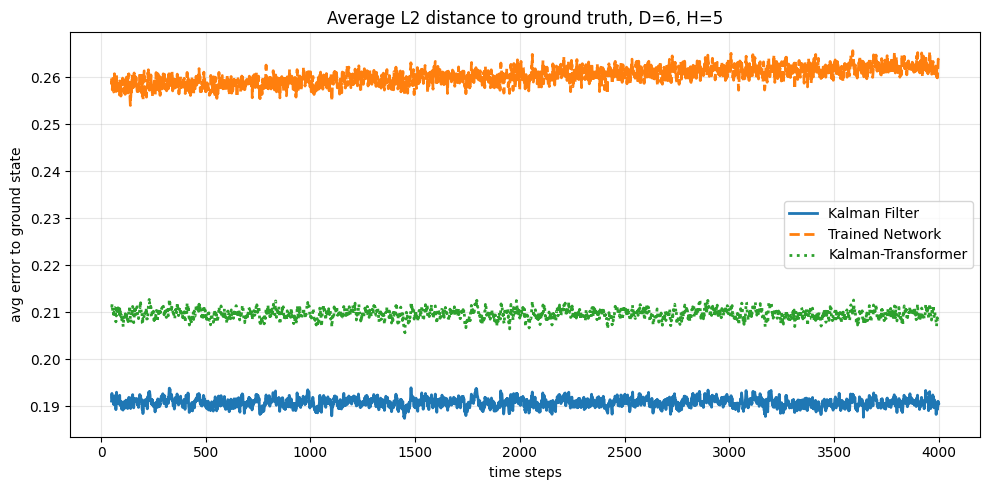

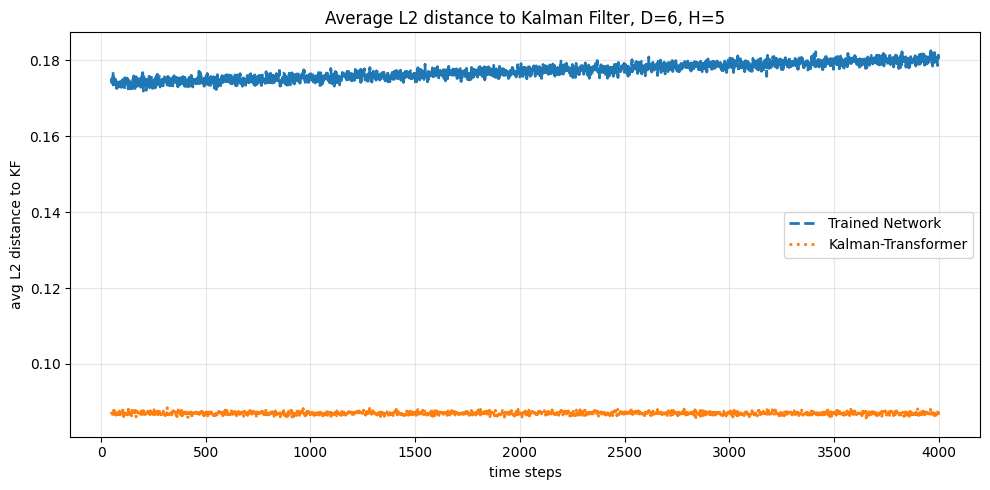

In [14]:
# =================
# Plotting
# =================
time = np.arange(T_eval)[50:]

# Figure 1: average L2 distance to ground truth
plt.figure(figsize=(10, 5))
plt.plot(time, mean_err_kf, label="Kalman Filter", linewidth=2)
plt.plot(time, mean_err_nn, label="Trained Network", linewidth=2, linestyle="--")
plt.plot(time, mean_err_tf, label="Kalman-Transformer", linewidth=2, linestyle=":")
plt.grid(True, alpha=0.3)
plt.xlabel("time steps")
plt.ylabel("avg error to ground state")
plt.title(f"Average L2 distance to ground truth, D={N}, H={History}")
plt.legend()
plt.tight_layout()
plt.show()

# Figure 2: distance to Kalman Filter (neural models)
plt.figure(figsize=(10, 5))
plt.plot(time, mean_dist_nn_kf, label="Trained Network", linewidth=2, linestyle="--")
plt.plot(time, mean_dist_tf_kf, label="Kalman-Transformer", linewidth=2, linestyle=":")
plt.grid(True, alpha=0.3)
plt.xlabel("time steps")
plt.ylabel("avg L2 distance to KF")
plt.title(f"Average L2 distance to Kalman Filter, D={N}, H={History}")
plt.legend()
plt.tight_layout()
plt.show()